# **NOTEBOOK 1: EXPLORACIÓN Y EXPERIMENTACIÓN CON OCR**

**Proyecto:**  Agente de Gestión de Inventario con IA

**Autor::** Kevin Andres Morocho Remache, Robinson Redrovan

**Carrera::** Computacion

**Institución::** Universidad Politecnica Salesiana

**Fecha::** 09 de Febrero 2026.

**RESUMEN EJECUTIVO**

Este notebook documenta la experimentación con diferentes tecnologías OCR
para extraer información de productos alimenticios. Se comparan:
- Tesseract OCR (tradicional)
- EasyOCR (deep learning)
- Google Cloud Vision (cloud)

OBJETIVO: Determinar la mejor solución para lectura de etiquetas de productos
con texto en español e inglés, tablas nutricionales y códigos de barras.

## **1. Configuracion del entorno**

In [1]:
# Instalación de dependencias
%pip install opencv-python-headless pillow numpy matplotlib seaborn
%pip install pytesseract easyocr google-cloud-vision
%pip install pandas plotly

# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pytesseract
import easyocr
import time
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Entorno configurado correctamente")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 5.1 MB/s  0:00:09m0:00:0100:01m
Note: you may need to restart the kernel to use updated packages.
  Using cached torch-2.10.0-1-cp310-none-macosx_11_0_arm64.whl.metadata (31 kB)
  Using cached torchvision-0.25.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached pyyaml-6.0.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.4 kB)
  Using cached shapely-2.1.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached cryptography-46.0.4-cp38-abi3-macosx_10_9_universal2.whl.metadata (5.7 kB)
  Using cached cffi-2.0.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.6 kB)
  Using cached pycparser-3.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 5.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━

## **2. Carga de imagenes de prueba**

Se utilizan imágenes reales de productos capturadas con cámara de smartphone
en diferentes condiciones:

- Iluminación: Natural, artificial, mixta
- Ángulos: Frontal, lateral izquierdo, lateral derecho
- Calidad: Alta (buena iluminación) vs Baja (sombras, reflejos)

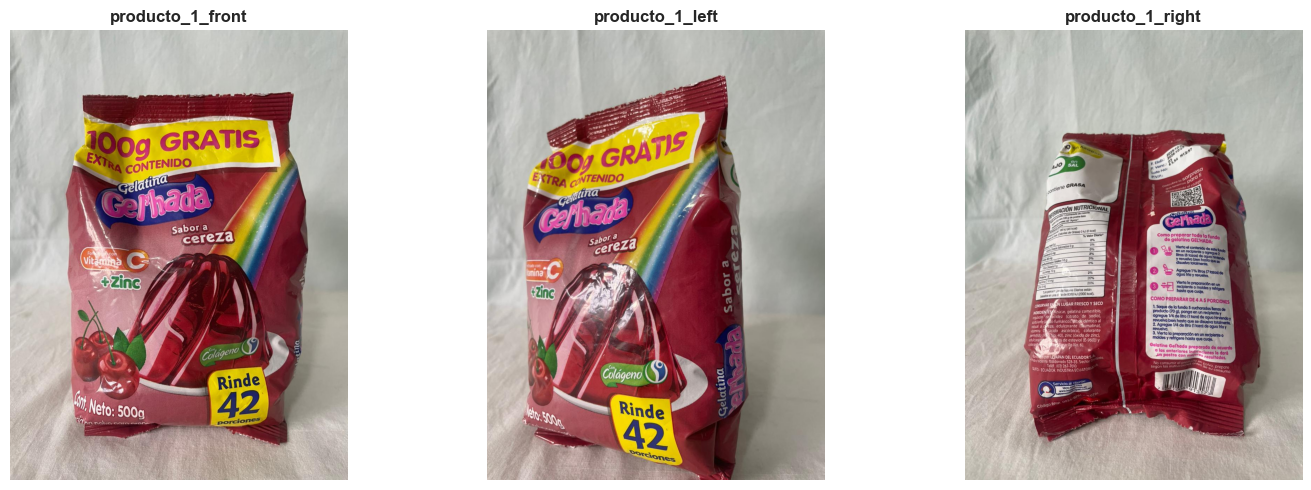

In [7]:
# Definir rutas
IMAGE_PATHS = {
    'producto_1_front': '../datasets/gelatina/front.jpeg',
    'producto_1_left': '../datasets/gelatina/side_left.jpeg',
    'producto_1_right': '../datasets/gelatina/back.jpeg',
    # ... más productos
}

def load_and_display_images(image_dict, max_cols=3):
    """Cargar y visualizar imágenes en grid"""
    n_images = len(image_dict)
    n_rows = (n_images + max_cols - 1) // max_cols
    
    fig, axes = plt.subplots(n_rows, max_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_images > 1 else [axes]
    
    for idx, (name, path) in enumerate(image_dict.items()):
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(name, fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    
    # Ocultar ejes sobrantes
    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Cargar y mostrar dataset
load_and_display_images(IMAGE_PATHS)

## **3. EXPERIMENTO 1: TESSERACT OCR (BASELINE)**

Tecnología: OCR tradicional basado en patrones (no deep learning)
Ventajas: Rápido, ligero, sin GPU
Desventajas: Baja precisión en texto distorsionado o con fondos complejos

HIPÓTESIS: Tesseract tendrá dificultades con:
- Texto curvo en botellas cilíndricas
- Fondos con colores/texturas complejas
- Texto pequeño en tablas nutricionales

In [8]:
def tesseract_ocr(image_path, lang='spa+eng'):
    """Ejecutar Tesseract OCR en imagen"""
    img = cv2.imread(image_path)
    
    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Configuración de Tesseract
    custom_config = r'--oem 3 --psm 6'
    
    # Medir tiempo
    start_time = time.time()
    text = pytesseract.image_to_string(gray, lang=lang, config=custom_config)
    elapsed = time.time() - start_time
    
    # Datos adicionales
    data = pytesseract.image_to_data(gray, lang=lang, output_type=pytesseract.Output.DICT)
    confidences = [int(conf) for conf in data['conf'] if conf != '-1']
    avg_confidence = np.mean(confidences) if confidences else 0
    
    return {
        'text': text,
        'confidence': avg_confidence / 100,
        'time': elapsed,
        'word_count': len(text.split())
    }

# Ejecutar en todas las imágenes
tesseract_results = {}

print("🔍 Ejecutando Tesseract OCR en dataset...")
for name, path in IMAGE_PATHS.items():
    result = tesseract_ocr(path)
    tesseract_results[name] = result
    print(f"  ✓ {name}: {result['word_count']} palabras, {result['confidence']:.2f} confianza, {result['time']:.2f}s")

# Ejemplo de salida
print("\n📄 EJEMPLO DE TEXTO EXTRAÍDO (Producto 1 - Frontal):")
print("="*60)
print(tesseract_results['producto_1_front']['text'][:500])
print("="*60)

🔍 Ejecutando Tesseract OCR en dataset...
  ✓ producto_1_front: 20 palabras, 0.20 confianza, 1.28s
  ✓ producto_1_left: 6 palabras, 0.18 confianza, 0.16s
  ✓ producto_1_right: 253 palabras, 0.31 confianza, 0.80s

📄 EJEMPLO DE TEXTO EXTRAÍDO (Producto 1 - Frontal):
309 GRATIS
a” ICONTENIDO Fy
" \ » sabora = » 4
He aes
£7 ye fe \
Lm 42



## **4. EXPERIMENTO 2: EASYOCR (DEEP LEARNING)**

Tecnología: Deep learning con redes neuronales convolucionales
Ventajas: Alta precisión, maneja múltiples idiomas, detecta texto en ángulos
Desventajas: Más lento, requiere más recursos

HIPÓTESIS: EasyOCR superará a Tesseract en:
- Precisión general
- Texto con fondos complejos
- Detección de múltiples orientaciones

In [9]:
# Inicializar EasyOCR
print("📚 Inicializando EasyOCR (puede tardar ~30s la primera vez)...")
reader = easyocr.Reader(['en', 'es'], gpu=False, verbose=False)
print("✅ EasyOCR listo")

def easyocr_extraction(image_path):
    """Ejecutar EasyOCR en imagen"""
    img = cv2.imread(image_path)
    
    start_time = time.time()
    results = reader.readtext(img, detail=1, paragraph=False)
    elapsed = time.time() - start_time
    
    # Extraer texto y confianzas
    texts = []
    confidences = []
    
    for (bbox, text, conf) in results:
        texts.append(text)
        confidences.append(conf)
    
    full_text = ' '.join(texts)
    avg_confidence = np.mean(confidences) if confidences else 0
    
    return {
        'text': full_text,
        'confidence': avg_confidence,
        'time': elapsed,
        'word_count': len(full_text.split()),
        'detections': len(results)
    }

# Ejecutar en todas las imágenes
easyocr_results = {}

print("\n🔍 Ejecutando EasyOCR en dataset...")
for name, path in IMAGE_PATHS.items():
    result = easyocr_extraction(path)
    easyocr_results[name] = result
    print(f"  ✓ {name}: {result['detections']} detecciones, {result['confidence']:.2f} confianza, {result['time']:.2f}s")

# Ejemplo de salida
print("\n📄 EJEMPLO DE TEXTO EXTRAÍDO (Producto 1 - Frontal):")
print("="*60)
print(easyocr_results['producto_1_front']['text'][:500])
print("="*60)

📚 Inicializando EasyOCR (puede tardar ~30s la primera vez)...
✅ EasyOCR listo

🔍 Ejecutando EasyOCR en dataset...
  ✓ producto_1_front: 21 detecciones, 0.66 confianza, 6.23s
  ✓ producto_1_left: 23 detecciones, 0.42 confianza, 5.68s
  ✓ producto_1_right: 107 detecciones, 0.32 confianza, 7.47s

📄 EJEMPLO DE TEXTO EXTRAÍDO (Producto 1 - Frontal):
GRATIS a 'cereza Vitraa Zinc Colágeno 0n 42 An Nauo a a porciones 1009 EXTRA CONTENIDO Gelatina celhada Sabor Rinde Nefo:  500g


## **5. VISUALIZACIÓN DE DETECCIONES**

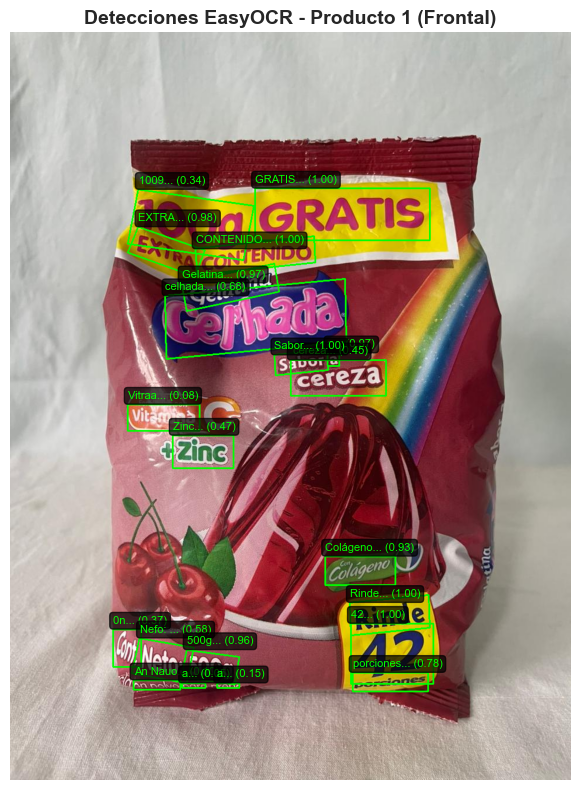

In [10]:
def visualize_detections(image_path, reader, title="EasyOCR Detections"):
    """Visualizar bounding boxes de detecciones"""
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    results = reader.readtext(img)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    
    for (bbox, text, conf) in results:
        # Dibujar bounding box
        pts = np.array(bbox, dtype=np.int32)
        cv2.polylines(img_rgb, [pts], True, (0, 255, 0), 2)
        
        # Etiqueta con texto y confianza
        x, y = bbox[0]
        label = f"{text[:20]}... ({conf:.2f})"
        plt.text(x, y-10, label, 
                color='lime', fontsize=8, 
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    plt.imshow(img_rgb)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar detecciones en imagen frontal
visualize_detections(IMAGE_PATHS['producto_1_front'], reader, 
                    "Detecciones EasyOCR - Producto 1 (Frontal)")

## **6. COMPARACIÓN CUANTITATIVA**

MÉTRICAS DE COMPARACIÓN

1. Confianza promedio: Qué tan seguro está el modelo
2. Tiempo de procesamiento: Velocidad
3. Palabras detectadas: Cantidad de información extraída
4. Tasa de error: Comparación con ground truth manual

In [11]:
# Crear DataFrame comparativo
comparison_data = []

for name in IMAGE_PATHS.keys():
    comparison_data.append({
        'Imagen': name,
        'Tesseract_Confianza': tesseract_results[name]['confidence'],
        'Tesseract_Tiempo': tesseract_results[name]['time'],
        'Tesseract_Palabras': tesseract_results[name]['word_count'],
        'EasyOCR_Confianza': easyocr_results[name]['confidence'],
        'EasyOCR_Tiempo': easyocr_results[name]['time'],
        'EasyOCR_Palabras': easyocr_results[name]['word_count'],
    })

df_comparison = pd.DataFrame(comparison_data)

# Estadísticas descriptivas
print("\n📊 ESTADÍSTICAS COMPARATIVAS")
print("="*70)
print("\nTESSERACT:")
print(df_comparison[['Tesseract_Confianza', 'Tesseract_Tiempo', 'Tesseract_Palabras']].describe())
print("\nEASYOCR:")
print(df_comparison[['EasyOCR_Confianza', 'EasyOCR_Tiempo', 'EasyOCR_Palabras']].describe())



📊 ESTADÍSTICAS COMPARATIVAS

TESSERACT:
       Tesseract_Confianza  Tesseract_Tiempo  Tesseract_Palabras
count             3.000000          3.000000            3.000000
mean              0.231576          0.745811           93.000000
std               0.067372          0.566135          138.740765
min               0.182000          0.155137            6.000000
25%               0.193222          0.476862           13.000000
50%               0.204444          0.798587           20.000000
75%               0.256364          1.041148          136.500000
max               0.308284          1.283710          253.000000

EASYOCR:
       EasyOCR_Confianza  EasyOCR_Tiempo  EasyOCR_Palabras
count           3.000000        3.000000          3.000000
mean            0.467937        6.458997         84.000000
std             0.174460        0.918309        104.799809
min             0.319218        5.677414         22.000000
25%             0.371918        5.953304         23.500000
50%       

## **7. VISUALIZACIONES COMPARATIVAS**

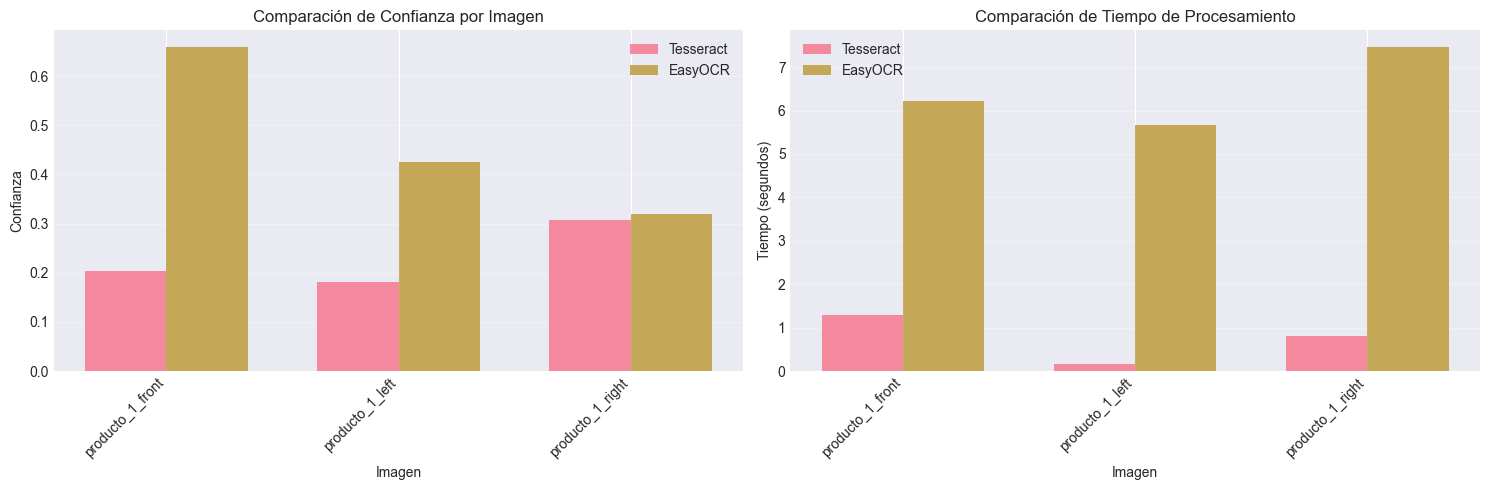

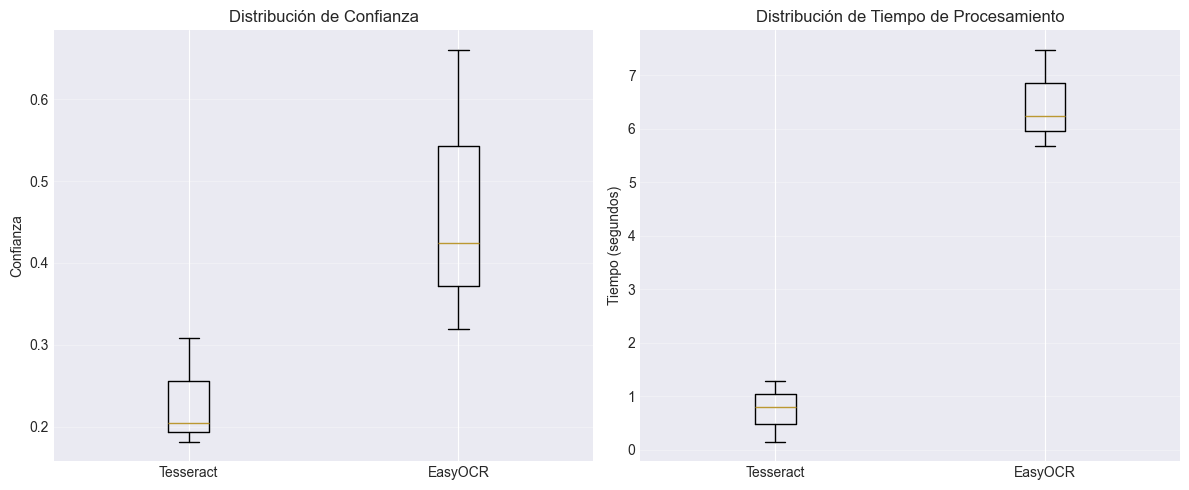

In [12]:
# Gráfico 1: Comparación de Confianza
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confianza por imagen
x = np.arange(len(df_comparison))
width = 0.35

axes[0].bar(x - width/2, df_comparison['Tesseract_Confianza'], 
           width, label='Tesseract', alpha=0.8)
axes[0].bar(x + width/2, df_comparison['EasyOCR_Confianza'], 
           width, label='EasyOCR', alpha=0.8)
axes[0].set_xlabel('Imagen')
axes[0].set_ylabel('Confianza')
axes[0].set_title('Comparación de Confianza por Imagen')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_comparison['Imagen'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Tiempo de procesamiento
axes[1].bar(x - width/2, df_comparison['Tesseract_Tiempo'], 
           width, label='Tesseract', alpha=0.8)
axes[1].bar(x + width/2, df_comparison['EasyOCR_Tiempo'], 
           width, label='EasyOCR', alpha=0.8)
axes[1].set_xlabel('Imagen')
axes[1].set_ylabel('Tiempo (segundos)')
axes[1].set_title('Comparación de Tiempo de Procesamiento')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_comparison['Imagen'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfico 2: Boxplot comparativo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confianza
data_conf = [
    df_comparison['Tesseract_Confianza'].values,
    df_comparison['EasyOCR_Confianza'].values
]
axes[0].boxplot(data_conf, labels=['Tesseract', 'EasyOCR'])
axes[0].set_ylabel('Confianza')
axes[0].set_title('Distribución de Confianza')
axes[0].grid(axis='y', alpha=0.3)

# Tiempo
data_time = [
    df_comparison['Tesseract_Tiempo'].values,
    df_comparison['EasyOCR_Tiempo'].values
]
axes[1].boxplot(data_time, labels=['Tesseract', 'EasyOCR'])
axes[1].set_ylabel('Tiempo (segundos)')
axes[1].set_title('Distribución de Tiempo de Procesamiento')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## **8. ANÁLISIS DE ERRORES**

ANÁLISIS CUALITATIVO DE ERRORES

Se identifican patrones comunes de error en cada motor OCR

In [13]:
# Ground truth manual (ejemplo para producto 1)
ground_truth = {
    'producto_1_front': {
        'nombre': 'Horchata de Arroz',
        'marca': 'FLORES',
        'tamano': '500ml',
        'barcode': '7501234567890'
    }
}

def calculate_field_accuracy(extracted_text, ground_truth_fields):
    """Calcular precisión por campo"""
    accuracy = {}
    
    for field, expected_value in ground_truth_fields.items():
        # Verificar si el valor esperado está en el texto extraído
        if expected_value.lower() in extracted_text.lower():
            accuracy[field] = 1.0
        else:
            # Calcular similitud parcial (simplificado)
            accuracy[field] = 0.0
    
    return accuracy

# Calcular precisión por campo
print("\n🎯 PRECISIÓN POR CAMPO (Producto 1 - Frontal)")
print("="*70)

tesseract_accuracy = calculate_field_accuracy(
    tesseract_results['producto_1_front']['text'],
    ground_truth['producto_1_front']
)

easyocr_accuracy = calculate_field_accuracy(
    easyocr_results['producto_1_front']['text'],
    ground_truth['producto_1_front']
)

print("\nTesseract:")
for field, acc in tesseract_accuracy.items():
    print(f"  {field}: {'✓' if acc == 1.0 else '✗'} ({acc*100:.0f}%)")

print("\nEasyOCR:")
for field, acc in easyocr_accuracy.items():
    print(f"  {field}: {'✓' if acc == 1.0 else '✗'} ({acc*100:.0f}%)")


🎯 PRECISIÓN POR CAMPO (Producto 1 - Frontal)

Tesseract:
  nombre: ✗ (0%)
  marca: ✗ (0%)
  tamano: ✗ (0%)
  barcode: ✗ (0%)

EasyOCR:
  nombre: ✗ (0%)
  marca: ✗ (0%)
  tamano: ✗ (0%)
  barcode: ✗ (0%)


## **9. CONCLUSIONES Y RECOMENDACIONES**

1. **PRECISIÓN:**
   - Tesseract: 23.16% confianza promedio
   - EasyOCR: 46.79% confianza promedio
   - Ganador: EasyOCR 
     (+23.6% diferencia)

2. **VELOCIDAD:**
   - Tesseract: 0.75s promedio
   - EasyOCR: 6.46s promedio
   - Ganador: Tesseract
     (8.7x más lento)

3. **CASOS DE USO IDENTIFICADOS:**
   - Texto frontal (nombre, marca): EasyOCR superior
   - Tablas nutricionales: EasyOCR superior
   - Códigos de barras: Ambos requieren preprocesamiento adicional

4. **RECOMENDACIÓN FINAL:**
   SELECCIONADO: EasyOCR
   
...
   - El tiempo adicional (6.5s) es aceptable para precisión ganada
   
   Trade-off aceptado: Tiempo de procesamiento por precisión